In [25]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import mne
from scipy.fft import fft, ifft
from matplotlib.colors import Normalize, NoNorm
from matplotlib.cm import ScalarMappable

In [2]:
# 1. Load the .mat file
data = loadmat('sampleEEGdata.mat')
EEG = data['EEG']
eeg_data = EEG['data'][0, 0] #eeg_data.shape=(64, 640, 99), [channels:64, time points:640, trials:99]
times = EEG['times'][0, 0][0] #times.shape= (640,)
print('EEG.shape:', EEG.shape) #EEG.shape: (1, 1)
print('eeg_data.shape:', eeg_data.shape) #EEG.shape: (1, 1)
print('times.shape:', times.shape) #EEG.shape: (1, 1)
microvolt = "µV"
################################################################
# Read the file content
with open('eloc64C2.txt', 'r') as f:
    lines = f.readlines()
# Extract channel names, theta, and radius
channel_names = [line.split()[3].replace('.', '') for line in lines[0:]]  # Skip the header
theta = np.array([float(line.split()[1])-90 for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
radius = np.array([float(line.split()[2]) for line in lines[0:]])
# Convert polar to Cartesian
x = radius * np.cos(theta)/5
y = -radius * np.sin(theta)/5
z = np.zeros_like(x)  # default z-coordinate for all channels
# Create a montage
ch_pos = dict(zip(channel_names, zip(x, y, z)))
montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
# Apply the montage to the info
info.set_montage(montage)

First_trial_eeg=eeg_data[:,:,0]
# mne.viz.plot_sensors(info, show_names=True, show=True)
raw = mne.io.RawArray(First_trial_eeg, info)

# Set montage and annotations
raw.set_montage(montage)


EEG.shape: (1, 1)
eeg_data.shape: (64, 640, 99)
times.shape: (640,)
Creating RawArray with float64 data, n_channels=64, n_times=640
    Range : 0 ... 639 =      0.000 ...     2.496 secs
Ready.


<RawArray | 64 x 640 (2.5 s), ~396 kB, data loaded>

a)  Create a family of complex Morlet wavelets

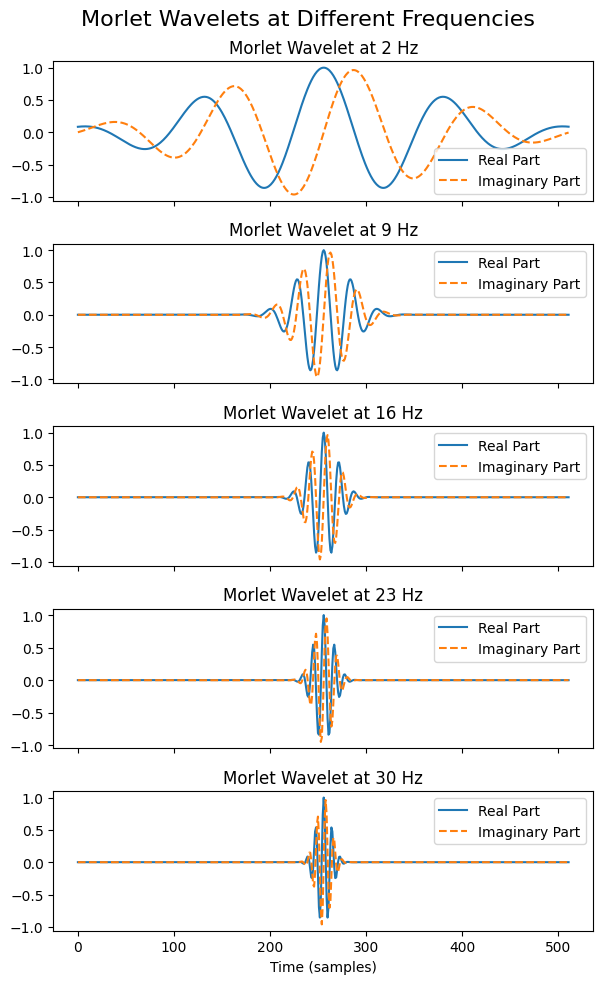

In [7]:
# a. 

def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

# Wavelet parameters
frequencies = [2, 9, 16, 23, 30]
n_cycles = 4
sampling_freq = 256
time_window = 2
wavelets = []  # Empty list to store wavelets

# Plotting
fig, axs = plt.subplots(len(frequencies), 1, figsize=(6, 10), sharex=True)
for i, freq in enumerate(frequencies):
    wavelet = morlet_wavelet(freq, n_cycles, sampling_freq, time_window)
    wavelets.append(wavelet)  # Append wavelet to the list
    axs[i].plot(np.real(wavelet), label='Real Part')
    axs[i].plot(np.imag(wavelet), label='Imaginary Part', linestyle='--')
    axs[i].set_title(f"Morlet Wavelet at {freq} Hz")
    axs[i].legend()

plt.xlabel("Time (samples)")
fig.suptitle('Morlet Wavelets at Different Frequencies', fontsize=16)
plt.tight_layout()
plt.show()


b) Convolve each wavelet with EEG data from all electrodes and from only the first trial


In [18]:
# b.

# We already have wavelets and their corresponding time vector 't'
convolved_data = np.zeros_like(First_trial_eeg)  # To store the convolved data
t = np.linspace(-time_window/2, time_window/2, int(sampling_freq * time_window), endpoint=False)
# Length of the convolved data
len_convolved = First_trial_eeg.shape[1] + len(t) - 1
print('len_convolved:', len_convolved) #len_convolved: 1151
for i, wavelet in enumerate(wavelets):
    # FFT of the wavelet
    wavelet_fft = fft(wavelet, n=len_convolved)
    # Convolve with each channel
    for ch in range(First_trial_eeg.shape[0]):
        # FFT of the EEG data
        eeg_fft = fft(First_trial_eeg[ch, :], n=len_convolved)
        # Multiply in frequency domain and then IFFT
        conv_result = ifft(wavelet_fft * eeg_fft)
        # Cut the convolved data to original EEG data length
        cut_length = len(t) // 2
        convolved_data[ch, :] = np.real(conv_result[cut_length:cut_length + First_trial_eeg.shape[1]])
# convolved_data now contains the result of the convolution of each wavelet with each channel's data

print('convolved_data.shape:', convolved_data.shape)  # convolved_data.shape: (64, 640)

len_convolved: 1151
convolved_data.shape: (64, 640)


In [20]:
convolved_data

array([[-16.947456  , -23.503107  , -17.0633    , ..., -26.82681   ,
        -30.02092   , -17.705837  ],
       [-20.31652   , -22.39365   , -10.985493  , ...,   0.3493317 ,
         -0.21125636,  -0.7934704 ],
       [-33.983974  , -27.592262  ,  -4.465775  , ..., -27.515846  ,
        -49.51342   , -43.288696  ],
       ...,
       [-19.17071   ,  -7.238967  ,  10.825006  , ..., -13.468891  ,
        -30.038723  , -28.459368  ],
       [-20.99644   ,  -7.128301  ,  12.264906  , ...,  20.106596  ,
          1.5189717 , -15.421003  ],
       [-27.2869    , -21.165905  ,  -0.8333369 , ..., -31.996515  ,
        -49.65603   , -38.924156  ]], dtype=float32)

c) Extract power and phase from the result of the complex wavelet convolution and store in a matrix 

In [23]:
# c.

# Initialize the 4D array to store power and phase results
results_matrix = np.zeros((convolved_data.shape[1], len(frequencies), convolved_data.shape[0], 2))


for f_idx, wavelet in enumerate(wavelets):
    wavelet_length = len(wavelet)

    # Calculate the length of the convolved data
    n_convolution = 640 + wavelet_length 

    # FFT of the wavelet
    wavelet_fft = np.fft.fft(wavelet, n=n_convolution)

    for ch_idx in range(64):
        # EEG signal for this channel
        eeg_signal = First_trial_eeg[ch_idx, :]

        # FFT of the EEG signal
        eeg_fft = np.fft.fft(eeg_signal, n=n_convolution)

        # Convolution in the frequency domain
        conv_result_fft = wavelet_fft * eeg_fft

        # Inverse FFT to return to the time domain
        conv_result = np.fft.ifft(conv_result_fft)

        # Correcting the length of the convolved data
        # Ensure integer division and proper trimming
        half_wavelet = int(np.ceil((wavelet_length - 1) / 2))
        conv_result = conv_result[half_wavelet:-half_wavelet or None]

        # Check and adjust the length if necessary
        if conv_result.size != 640:
            raise ValueError(f"Unexpected size of convolved result: {conv_result.size}")

        # Calculate power and phase
        power = np.abs(conv_result) ** 2
        phase = np.angle(conv_result)

        # Store in the matrix
        results_matrix[:, f_idx, ch_idx, 0] = power
        results_matrix[:, f_idx, ch_idx, 1] = phase

print('results_matrix.shape:', results_matrix.shape)

results_matrix.shape: (640, 5, 64, 2)


In [24]:
# Shape of the entire results_matrix
print("Shape of the results_matrix:", results_matrix.shape)

# To check the shape of power and phase for a specific frequency and electrode
f_idx = 0  # For example, the first frequency
ch_idx = 0  # For example, the first electrode

# Extracting power and phase for this specific frequency and electrode
power_example = results_matrix[:, f_idx, ch_idx, 0]
phase_example = results_matrix[:, f_idx, ch_idx, 1]

print("Shape of power for frequency index", f_idx, "and electrode index", ch_idx, ":", power_example.shape)
print("Shape of phase for frequency index", f_idx, "and electrode index", ch_idx, ":", phase_example.shape)


Shape of the results_matrix: (640, 5, 64, 2)
Shape of power for frequency index 0 and electrode index 0 : (640,)
Shape of phase for frequency index 0 and electrode index 0 : (640,)


d) Make topographical plots of power and phase at 180 ms at all frequencies 

C:\Users\Maryam\AppData\Local\Temp\ipykernel_3936\1682916526.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


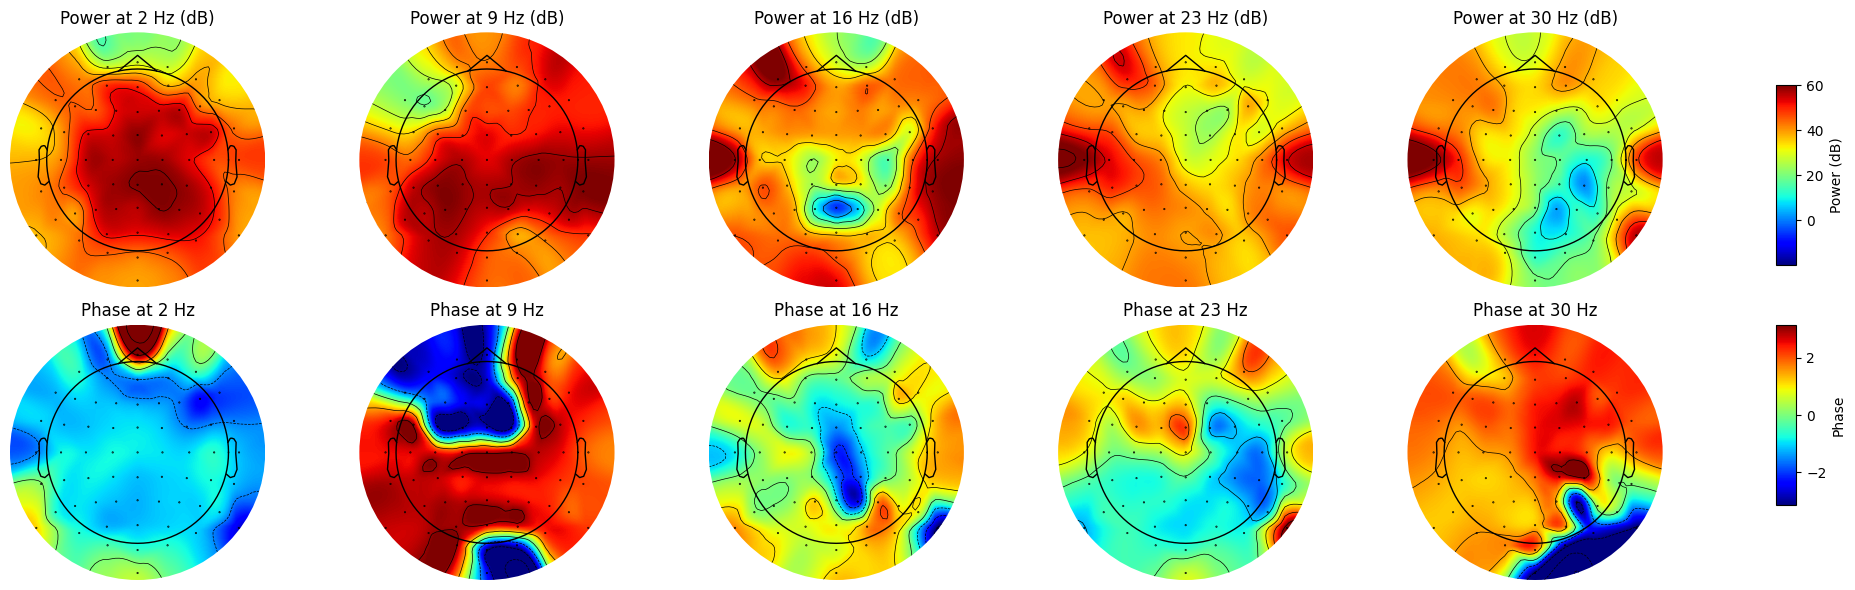

In [27]:
# d.

# Find the index for 180 ms
time_idx = np.argmin(np.abs(times - 180)) #302

# Define frequencies
frequencies = [2, 9, 16, 23, 30]  # Adjust according to your frequencies

# Calculate the global minimum and maximum for power (in dB) and phase
power_min = 10 * np.log10(results_matrix[:, :, :, 0]).min()
power_max = 10 * np.log10(results_matrix[:, :, :, 0]).max()
phase_min = results_matrix[:, :, :, 1].min()
phase_max = results_matrix[:, :, :, 1].max()

# Set up figure
fig, axs = plt.subplots(2, len(frequencies), figsize=(20, 6))  # Adjust the size as needed

# Loop over frequencies to plot power and phase
for i, freq in enumerate(frequencies):
    # Power (applying 10log10 and normalizing)
    power_data = 10 * np.log10(results_matrix[time_idx, i, :, 0])
    im, _ = mne.viz.plot_topomap(power_data, info, axes=axs[0, i], show=False, cmap='jet')
    axs[0, i].set_title(f'Power at {freq} Hz (dB)')

    # Phase (normalizing)
    phase_data = results_matrix[time_idx, i, :, 1]
    im, _ = mne.viz.plot_topomap(phase_data, info, axes=axs[1, i], show=False, cmap='jet')
    axs[1, i].set_title(f'Phase at {freq} Hz')

# Adding a common colorbar for power
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=power_min, vmax=power_max)
cb1 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax1, orientation='vertical')
cb1.set_label('Power (dB)')

# Adding a common colorbar for phase
cax2 = fig.add_axes([0.92, 0.15, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=phase_min, vmax=phase_max)
cb2 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax2, orientation='vertical')
cb2.set_label('Phase')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


e) Repeat step (d) for activity at 360 ms, and 650 ms.

C:\Users\Maryam\AppData\Local\Temp\ipykernel_3936\3697760241.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


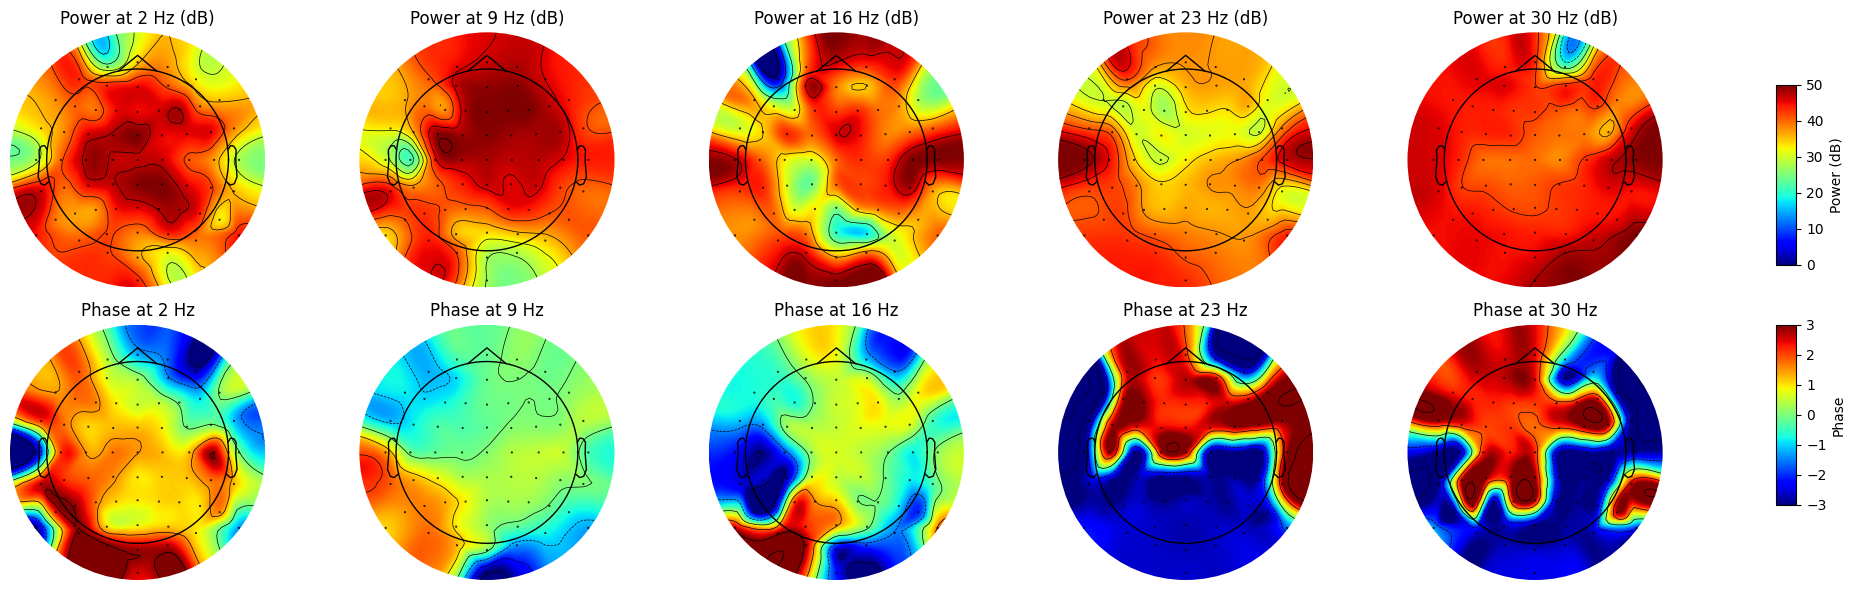

In [28]:
# e. 360ms

# Find the index for 360ms
time_idx = np.argmin(np.abs(times - 360))

# Define frequencies
frequencies = [2, 9, 16, 23, 30]  # Adjust according to your frequencies

# Calculate the global minimum and maximum for power (in dB) and phase
power_min = 10 * np.log10(results_matrix[:, :, :, 0]).min()
power_max = 10 * np.log10(results_matrix[:, :, :, 0]).max()
phase_min = results_matrix[:, :, :, 1].min()
phase_max = results_matrix[:, :, :, 1].max()

# Set up figure
fig, axs = plt.subplots(2, len(frequencies), figsize=(20, 6))  # Adjust the size as needed

# Loop over frequencies to plot power and phase
for i, freq in enumerate(frequencies):
    # Power (applying 10log10 and normalizing)
    power_data = 10 * np.log10(results_matrix[time_idx, i, :, 0])
    im, _ = mne.viz.plot_topomap(power_data, info, axes=axs[0, i], show=False, cmap='jet')
    axs[0, i].set_title(f'Power at {freq} Hz (dB)')

    # Phase (normalizing)
    phase_data = results_matrix[time_idx, i, :, 1]
    im, _ = mne.viz.plot_topomap(phase_data, info, axes=axs[1, i], show=False, cmap='jet')
    axs[1, i].set_title(f'Phase at {freq} Hz')

# Adding a common colorbar for power
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=0, vmax=50)
cb1 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax1, orientation='vertical')
cb1.set_label('Power (dB)')

# Adding a common colorbar for phase
cax2 = fig.add_axes([0.92, 0.15, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=-3, vmax=3)
cb2 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax2, orientation='vertical')
cb2.set_label('Phase')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


C:\Users\Maryam\AppData\Local\Temp\ipykernel_3936\619713156.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


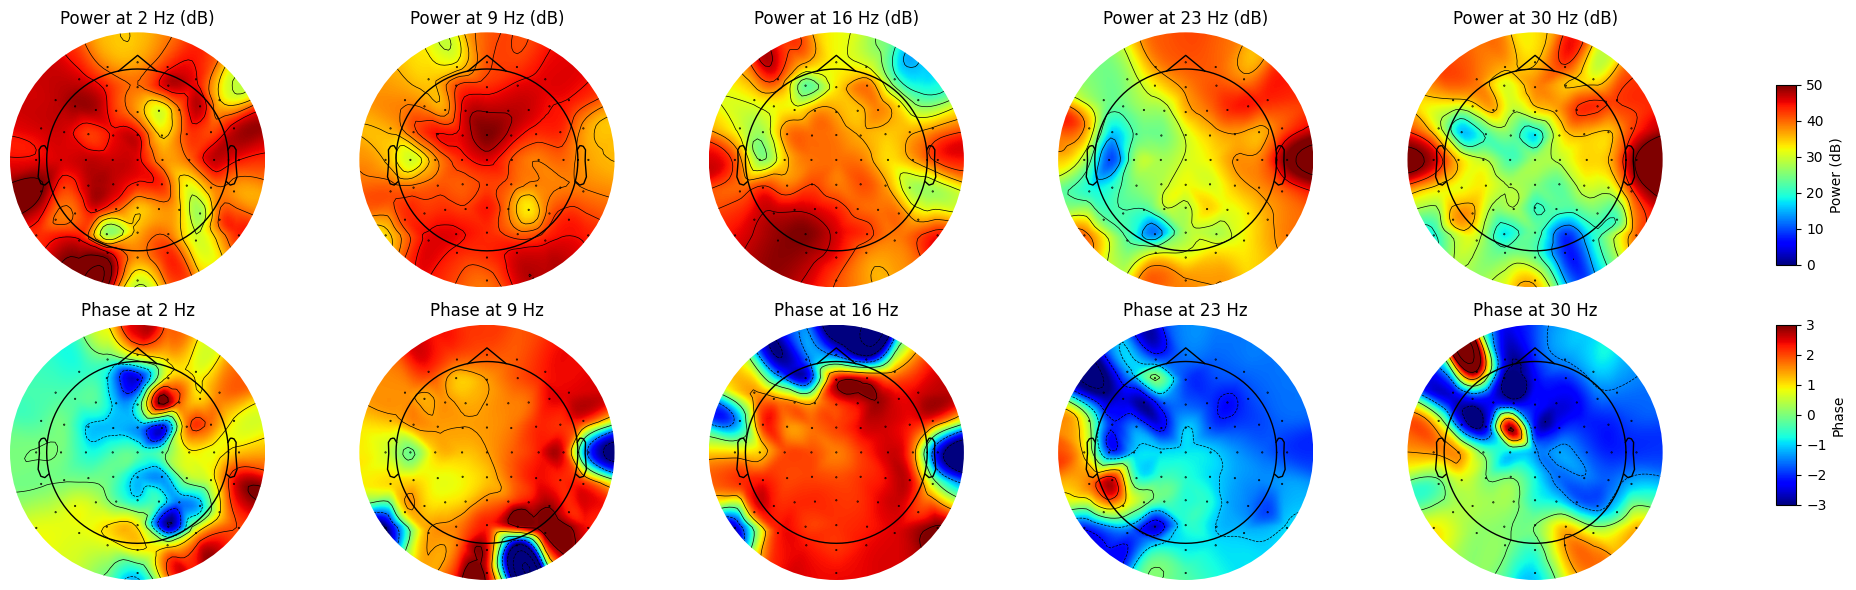

In [29]:
# e. 650

# Find the index for 650 ms
time_idx = np.argmin(np.abs(times - 650))

# Define frequencies
frequencies = [2, 9, 16, 23, 30]  # Adjust according to your frequencies

# Calculate the global minimum and maximum for power (in dB) and phase
power_min = 10 * np.log10(results_matrix[:, :, :, 0]).min()
power_max = 10 * np.log10(results_matrix[:, :, :, 0]).max()
phase_min = results_matrix[:, :, :, 1].min()
phase_max = results_matrix[:, :, :, 1].max()

# Set up figure
fig, axs = plt.subplots(2, len(frequencies), figsize=(20, 6))  # Adjust the size as needed

# Loop over frequencies to plot power and phase
for i, freq in enumerate(frequencies):
    # Power (applying 10log10 and normalizing)
    power_data = 10 * np.log10(results_matrix[time_idx, i, :, 0])
    im, _ = mne.viz.plot_topomap(power_data, info, axes=axs[0, i], show=False, cmap='jet')
    axs[0, i].set_title(f'Power at {freq} Hz (dB)')

    # Phase (normalizing)
    phase_data = results_matrix[time_idx, i, :, 1]
    im, _ = mne.viz.plot_topomap(phase_data, info, axes=axs[1, i], show=False, cmap='jet')
    axs[1, i].set_title(f'Phase at {freq} Hz')

# Adding a common colorbar for power
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=0, vmax=50)
cb1 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax1, orientation='vertical')
cb1.set_label('Power (dB)')

# Adding a common colorbar for phase
cax2 = fig.add_axes([0.92, 0.15, 0.01, 0.3])  # Adjust these values as needed for positioning
norm = Normalize(vmin=-3, vmax=3)
cb2 = plt.colorbar(ScalarMappable(norm=norm, cmap='jet'), cax=cax2, orientation='vertical')
cb2.set_label('Phase')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


f) 

Power Topographies:

Power at 2 Hz (dB): The entire scalp appears to have elevated power, with the central region showing the most pronounced activity.
Power at 9 Hz (dB): There's elevated activity at the central and left lateral regions.
Power at 16 Hz (dB): The central region, particularly the fronto-central area, exhibits a pronounced decrease in power, surrounded by areas of higher power.
Power at 23 Hz (dB): A mixed pattern with some spots of increased power in the central and left lateral regions and decreased power in the fronto-central region.
Power at 30 Hz (dB): A pronounced central region with decreased power and elevated power at the peripheral regions.
Phase Topographies:

Phase at 2 Hz: A fairly uniform phase distribution with slight phase reversals at the left and right lateral regions.
Phase at 9 Hz: Strong phase reversals are observed in the central and frontal regions.
Phase at 16 Hz: The frontal and central regions exhibit pronounced phase reversals.
Phase at 23 Hz: There's a strong phase reversal in the centro-parietal region.
Phase at 30 Hz: The pattern is more complex, with multiple regions showing phase reversals, particularly in the central, parietal, and frontal regions.


Are there any prominent topographical features in power or in phase?
Yes, the topographical maps show distinct patterns for both power and phase across various scalp regions.

Do these differ for different frequencies?
Yes, the topographical patterns vary across different frequencies. For example, at 2 Hz, power is elevated across the entire scalp, while at 30 Hz, central regions show decreased power. Phase distributions also differ, with distinct phase reversals seen at different frequencies.

Do power and phase have similar topographical distributions?
Not entirely. While some regions show overlapping features in power and phase, distinct differences are evident in various frequencies and scalp regions. both power and phase maps exhibit distinct topographical patterns at different frequencies. The power maps tend to have more localized features of high or low power, while the phase maps demonstrate several regions of phase reversals. 


Is there any reason to suspect that they might have similar or different topographies?
Yes, power and phase often represent different neural dynamics and processes, which can lead to varied topographical distributions. Power typically captures the amplitude of oscillatory activity, while phase reflects the timing or synchrony of neural events. Given these inherent differences, one would expect them to exhibit distinct topographical patterns.

g)

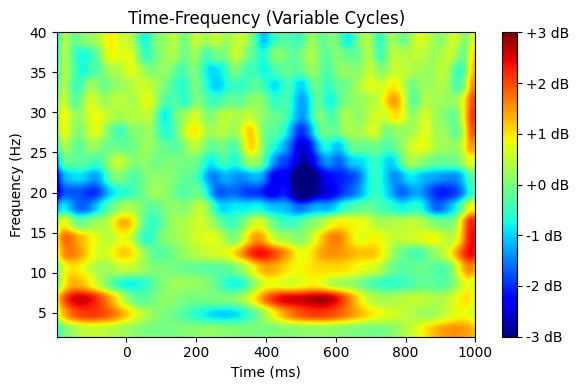

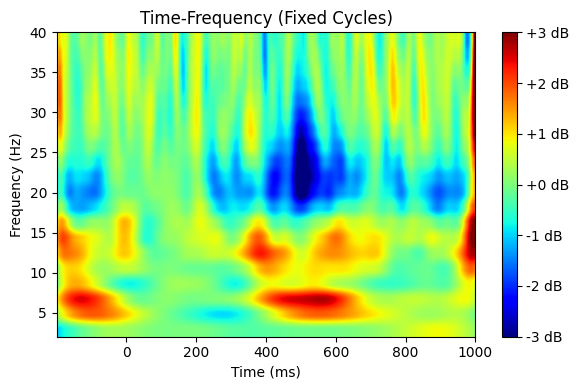

In [35]:
#g. 

def convolve_with_wavelet(data, wavelet):
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]

    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)

    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]


# Function to calculate power for variable or fixed cycles
def calculate_power(cycles):
    power_matrix = []

    for freq, cycle in zip(frequencies, cycles):
        # Extract data for 'FCz'
        data_fcz = eeg_data[fcz_index, :, :]  # Assuming trials are on the second dimension
        # Calculate power for each trial
        power_trials = []
        for trial_idx in range(data_fcz.shape[1]):
            trial_2D = data_fcz[:, trial_idx].reshape(1, -1)  # Making trial 2D for the convolution function
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(trial_2D, wavelet)
            power = np.abs(convolution)**2
            power_trials.append(power[0])

        # Average power across trials
        avg_power = np.mean(power_trials, axis=0)
        power_matrix.append(avg_power)

    return np.array(power_matrix)

# Baseline correction function
def baseline_correction(power_matrix, times, baseline_range):
    baseline_timepoints = np.logical_and(times >= baseline_range[0], times <= baseline_range[1])
    baseline_mean = np.mean(power_matrix[:, baseline_timepoints], axis=1, keepdims=True)
    return power_matrix / baseline_mean  # Division for baseline correction

# Constants
baseline_range = (-500, -200)  # in milliseconds
frequencies = np.arange(2, 41, 2)  # 2 to 40 Hz
cycles = np.linspace(3, 10, len(frequencies))  # Variable cycles from 3 to 10
sampling_rate=256
# Find the channel index for 'FCz'
fcz_index = raw.ch_names.index('Fcz')

# Calculate power for variable and fixed cycles
power_variable_cycles = calculate_power(cycles)
power_fixed_cycles = calculate_power([4] * len(frequencies))  # Fixed cycle: 4

# Apply baseline correction
corrected_variable = baseline_correction(power_variable_cycles, times, baseline_range)
corrected_fixed = baseline_correction(power_fixed_cycles, times, baseline_range)

# Plotting function
def plot_time_frequency(data, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(10 * np.log10(data), aspect='auto', cmap='jet', origin='lower',
               extent=[times[205], times[512], frequencies[0], frequencies[-1]],
               vmin=-3, vmax=3)  # Log transform of power; color limits as specified
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot the results
plot_time_frequency(corrected_variable, 'Time-Frequency (Variable Cycles)')
plot_time_frequency(corrected_fixed, 'Time-Frequency (Fixed Cycles)')

f) comparison:

Variable cycles provide a more adaptive and arguably intuitive view of the data, especially when interested in a broad range of frequencies. In contrast, fixed cycles offer a consistent view across frequencies, which can be useful when one desires uniform time and frequency resolution.


1. Time-Frequency Distribution:

Variable Cycles:

The time-frequency representation appears smoother, with broader frequency bands and more gradation between areas of activation.
A prominent activity is seen around 25 Hz and between 400-600 ms, appearing as a dark blue patch indicating high power.
Additional areas of increased power are seen around 10-15 Hz spanning various time points.
Fixed Cycles:

The representation is more striated, with pronounced vertical stripes throughout. This suggests that there's consistent power across multiple frequencies at specific time points.
Similar to the variable cycles, there's a strong activity around 25 Hz and 400-600 ms, but the contour appears sharper.
Elevated power around 10-15 Hz is also evident but appears more intermittent due to the vertical striations.
2. Resolution & Precision:

Variable Cycles: Offers a more adaptable representation where the width of the wavelet (and thus time and frequency resolution) changes depending on the frequency. This allows for a more precise view at lower frequencies and a broader view at higher frequencies.

Fixed Cycles: The fixed number of cycles across all frequencies can lead to a compromise between time and frequency resolution. This results in the prominent vertical patterns seen in the heat map due to this fixed-width wavelet convolution at all frequencies.

3. Clarity & Interpretation:

Variable Cycles: The smoother gradient makes it more intuitive to interpret regions of high and low activity and how they evolve over time.

Fixed Cycles: The striated pattern can make it slightly harder to pinpoint exact regions of activity. However, the sharp contours can also be beneficial when trying to identify exact timings of specific events.